# Linear Regression on House Prices (1D) with Keras

In this notebook we show how to perform linear regression on house prices data, using Keras.

## Define `X_train` and `Y_train`

In [1]:
import pandas as pd
import numpy as np
from numpy import transpose
from numpy import append
from numpy import reshape
import matplotlib.pyplot as plt
# %matplotlib notebook
import seaborn as sns

np.random.seed(42)
# tf.random.set_seed(42)
pd.set_option('display.max_columns', 100)

In [2]:
data = pd.read_csv('sources/train.csv')
data_id = data['Id']
data.drop('Id',axis = 1, inplace = True)
data.fillna(0, inplace=True)
print(data.shape)

data_num = data.select_dtypes(exclude=['object'])

data_cat = data.select_dtypes(include=['object'])
data_cat = pd.get_dummies(data_cat)

(1460, 80)


In [3]:
# Suppression des outliers
remove_outliers = False
if remove_outliers:
    from sklearn.ensemble import IsolationForest

    clf = IsolationForest(max_samples = 100, random_state = 42)
    clf.fit(data_num)
    y_noano = clf.predict(data_num)
    y_noano = pd.DataFrame(y_noano, columns = ['Top'])
    y_noano[y_noano['Top'] == 1].index.values

    data_num = data_num.iloc[y_noano[y_noano['Top'] == 1].index.values]
    data_num.reset_index(drop = True, inplace = True)
    print("Number of Outliers:", y_noano[y_noano['Top'] == -1].shape[0])
    print("Number of rows without outliers:", data_num.shape[0])

In [19]:
# On insère les données dons des arrays Numpuy
Y_train = data.SalePrice.values.astype(int)

X_train_num = np.matrix(data_num)
X_train_cat = np.matrix(data_cat)

X_train = append(X_train_num, values=X_train_cat, axis=1)

print(f"X train {X_train.shape}")
print(f"Y train {Y_train.shape}")

X train (1460, 305)
Y train (1460,)


### Scale features

"Normalizing" the data should help prevent values from "exploding":

In [20]:
scale_data = False
if scale_data:
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)

## Model Sequential avec Keras
Define input layer. Number of neurons = number of features in `x`.

Define output layer, with 1 neuron.
`Dense` creates _fully-connected_ layer.

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
model = Sequential()
model = Sequential([
    Input(shape=X_train.shape[1:]),
    Dense(1)
])

## Set up optimizer and "compile" model
In Keras, optimizer is specified when "compiling" model.
(Last step to fix model training code!)

In [22]:
from tensorflow.keras.optimizers import SGD
loss="mse"
LEARNING_RATE = 0.001
model.compile(loss=loss, optimizer=SGD(lr=LEARNING_RATE))

## Fit model (i.e. run optimization)

The model still hasn't "seen" any data yet...

* With SGD we can choose the amount of data to be used to compute the loss function (`BATCH_SIZE`). This can be useful when the whole dataset doesn't fit in memory. We'll revisit this later!
* We need to choose for how many iterations to run SGD (`EPOCHS`).
* The `fit` method is a loop over epochs and batches!

In [23]:
BATCH_SIZE = X_train.shape[0] # computing the loss over the whole dataset
EPOCHS = 2000 # how many iterations over the whole dataset
history = model.fit(X_train, Y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)

Train on 1460 samples
Epoch 1/2000
1460/1460 [==============================] - 0s 105us/sample - loss: 45039837184.0000
Epoch 2/2000
1460/1460 [==============================] - 0s 3us/sample - loss: 276434273612384844447219712.0000
Epoch 3/2000
1460/1460 [==============================] - 0s 2us/sample - loss: inf
Epoch 4/2000
1460/1460 [==============================] - 0s 3us/sample - loss: inf
Epoch 5/2000
1460/1460 [==============================] - 0s 5us/sample - loss: inf
Epoch 6/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 7/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 8/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 9/2000
1460/1460 [==============================] - 0s 4us/sample - loss: nan
Epoch 10/2000
1460/1460 [==============================] - 0s 4us/sample - loss: nan
Epoch 11/2000
1460/1460 [==============================] - 0s 4us/sample - loss: nan
Epoch 12

Epoch 97/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 98/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 99/2000
1460/1460 [==============================] - 0s 4us/sample - loss: nan
Epoch 100/2000
1460/1460 [==============================] - 0s 4us/sample - loss: nan
Epoch 101/2000
1460/1460 [==============================] - 0s 4us/sample - loss: nan
Epoch 102/2000
1460/1460 [==============================] - 0s 2us/sample - loss: nan
Epoch 103/2000
1460/1460 [==============================] - 0s 4us/sample - loss: nan
Epoch 104/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 105/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 106/2000
1460/1460 [==============================] - 0s 5us/sample - loss: nan
Epoch 107/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 108/2000
1460/1460 [==============================]

Epoch 193/2000
1460/1460 [==============================] - 0s 4us/sample - loss: nan
Epoch 194/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 195/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 196/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 197/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 198/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 199/2000
1460/1460 [==============================] - 0s 2us/sample - loss: nan
Epoch 200/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 201/2000
1460/1460 [==============================] - 0s 4us/sample - loss: nan
Epoch 202/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 203/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 204/2000
1460/1460 [============================

Epoch 289/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 290/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 291/2000
1460/1460 [==============================] - 0s 4us/sample - loss: nan
Epoch 292/2000
1460/1460 [==============================] - 0s 4us/sample - loss: nan
Epoch 293/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 294/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 295/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 296/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 297/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 298/2000
1460/1460 [==============================] - 0s 4us/sample - loss: nan
Epoch 299/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 300/2000
1460/1460 [============================

Epoch 385/2000
1460/1460 [==============================] - 0s 4us/sample - loss: nan
Epoch 386/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 387/2000
1460/1460 [==============================] - 0s 4us/sample - loss: nan
Epoch 388/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 389/2000
1460/1460 [==============================] - 0s 4us/sample - loss: nan
Epoch 390/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 391/2000
1460/1460 [==============================] - 0s 4us/sample - loss: nan
Epoch 392/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 393/2000
1460/1460 [==============================] - 0s 4us/sample - loss: nan
Epoch 394/2000
1460/1460 [==============================] - 0s 4us/sample - loss: nan
Epoch 395/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 396/2000
1460/1460 [============================

Epoch 481/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 482/2000
1460/1460 [==============================] - 0s 5us/sample - loss: nan
Epoch 483/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 484/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 485/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 486/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 487/2000
1460/1460 [==============================] - 0s 5us/sample - loss: nan
Epoch 488/2000
1460/1460 [==============================] - 0s 4us/sample - loss: nan
Epoch 489/2000
1460/1460 [==============================] - 0s 4us/sample - loss: nan
Epoch 490/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 491/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 492/2000
1460/1460 [============================

Epoch 577/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 578/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 579/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 580/2000
1460/1460 [==============================] - 0s 4us/sample - loss: nan
Epoch 581/2000
1460/1460 [==============================] - 0s 4us/sample - loss: nan
Epoch 582/2000
1460/1460 [==============================] - 0s 4us/sample - loss: nan
Epoch 583/2000
1460/1460 [==============================] - 0s 6us/sample - loss: nan
Epoch 584/2000
1460/1460 [==============================] - 0s 4us/sample - loss: nan
Epoch 585/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 586/2000
1460/1460 [==============================] - 0s 4us/sample - loss: nan
Epoch 587/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 588/2000
1460/1460 [============================

Epoch 673/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 674/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 675/2000
1460/1460 [==============================] - 0s 4us/sample - loss: nan
Epoch 676/2000
1460/1460 [==============================] - 0s 4us/sample - loss: nan
Epoch 677/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 678/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 679/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 680/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 681/2000
1460/1460 [==============================] - 0s 4us/sample - loss: nan
Epoch 682/2000
1460/1460 [==============================] - 0s 2us/sample - loss: nan
Epoch 683/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 684/2000
1460/1460 [============================

Epoch 769/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 770/2000
1460/1460 [==============================] - 0s 4us/sample - loss: nan
Epoch 771/2000
1460/1460 [==============================] - 0s 2us/sample - loss: nan
Epoch 772/2000
1460/1460 [==============================] - 0s 4us/sample - loss: nan
Epoch 773/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 774/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 775/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 776/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 777/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 778/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 779/2000
1460/1460 [==============================] - 0s 4us/sample - loss: nan
Epoch 780/2000
1460/1460 [============================

Epoch 865/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 866/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 867/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 868/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 869/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 870/2000
1460/1460 [==============================] - 0s 4us/sample - loss: nan
Epoch 871/2000
1460/1460 [==============================] - 0s 4us/sample - loss: nan
Epoch 872/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 873/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 874/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 875/2000
1460/1460 [==============================] - 0s 4us/sample - loss: nan
Epoch 876/2000
1460/1460 [============================

Epoch 961/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 962/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 963/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 964/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 965/2000
1460/1460 [==============================] - 0s 4us/sample - loss: nan
Epoch 966/2000
1460/1460 [==============================] - 0s 2us/sample - loss: nan
Epoch 967/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 968/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 969/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 970/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 971/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 972/2000
1460/1460 [============================

Epoch 1056/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1057/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1058/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1059/2000
1460/1460 [==============================] - 0s 4us/sample - loss: nan
Epoch 1060/2000
1460/1460 [==============================] - 0s 4us/sample - loss: nan
Epoch 1061/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1062/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1063/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1064/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1065/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1066/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1067/2000
1460/1460 [================

1460/1460 [==============================] - 0s 4us/sample - loss: nan
Epoch 1151/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1152/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1153/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1154/2000
1460/1460 [==============================] - 0s 2us/sample - loss: nan
Epoch 1155/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1156/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1157/2000
1460/1460 [==============================] - 0s 2us/sample - loss: nan
Epoch 1158/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1159/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1160/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1161/2000
1460/1460 [==============================] 

Epoch 1245/2000
1460/1460 [==============================] - 0s 4us/sample - loss: nan
Epoch 1246/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1247/2000
1460/1460 [==============================] - 0s 4us/sample - loss: nan
Epoch 1248/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1249/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1250/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1251/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1252/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1253/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1254/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1255/2000
1460/1460 [==============================] - 0s 4us/sample - loss: nan
Epoch 1256/2000
1460/1460 [================

1460/1460 [==============================] - 0s 4us/sample - loss: nan
Epoch 1340/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1341/2000
1460/1460 [==============================] - 0s 4us/sample - loss: nan
Epoch 1342/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1343/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1344/2000
1460/1460 [==============================] - 0s 2us/sample - loss: nan
Epoch 1345/2000
1460/1460 [==============================] - 0s 4us/sample - loss: nan
Epoch 1346/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1347/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1348/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1349/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1350/2000
1460/1460 [==============================] 

Epoch 1434/2000
1460/1460 [==============================] - 0s 2us/sample - loss: nan
Epoch 1435/2000
1460/1460 [==============================] - 0s 2us/sample - loss: nan
Epoch 1436/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1437/2000
1460/1460 [==============================] - 0s 2us/sample - loss: nan
Epoch 1438/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1439/2000
1460/1460 [==============================] - 0s 2us/sample - loss: nan
Epoch 1440/2000
1460/1460 [==============================] - 0s 4us/sample - loss: nan
Epoch 1441/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1442/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1443/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1444/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1445/2000
1460/1460 [================

1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1529/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1530/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1531/2000
1460/1460 [==============================] - 0s 2us/sample - loss: nan
Epoch 1532/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1533/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1534/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1535/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1536/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1537/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1538/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1539/2000
1460/1460 [==============================] 

Epoch 1623/2000
1460/1460 [==============================] - 0s 4us/sample - loss: nan
Epoch 1624/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1625/2000
1460/1460 [==============================] - 0s 5us/sample - loss: nan
Epoch 1626/2000
1460/1460 [==============================] - 0s 4us/sample - loss: nan
Epoch 1627/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1628/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1629/2000
1460/1460 [==============================] - 0s 4us/sample - loss: nan
Epoch 1630/2000
1460/1460 [==============================] - 0s 2us/sample - loss: nan
Epoch 1631/2000
1460/1460 [==============================] - 0s 4us/sample - loss: nan
Epoch 1632/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1633/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1634/2000
1460/1460 [================

1460/1460 [==============================] - 0s 4us/sample - loss: nan
Epoch 1718/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1719/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1720/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1721/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1722/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1723/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1724/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1725/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1726/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1727/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1728/2000
1460/1460 [==============================] 

Epoch 1812/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1813/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1814/2000
1460/1460 [==============================] - 0s 4us/sample - loss: nan
Epoch 1815/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1816/2000
1460/1460 [==============================] - 0s 5us/sample - loss: nan
Epoch 1817/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1818/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1819/2000
1460/1460 [==============================] - 0s 4us/sample - loss: nan
Epoch 1820/2000
1460/1460 [==============================] - 0s 2us/sample - loss: nan
Epoch 1821/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1822/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1823/2000
1460/1460 [================

1460/1460 [==============================] - 0s 4us/sample - loss: nan
Epoch 1907/2000
1460/1460 [==============================] - 0s 5us/sample - loss: nan
Epoch 1908/2000
1460/1460 [==============================] - 0s 5us/sample - loss: nan
Epoch 1909/2000
1460/1460 [==============================] - 0s 5us/sample - loss: nan
Epoch 1910/2000
1460/1460 [==============================] - 0s 5us/sample - loss: nan
Epoch 1911/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1912/2000
1460/1460 [==============================] - 0s 4us/sample - loss: nan
Epoch 1913/2000
1460/1460 [==============================] - 0s 4us/sample - loss: nan
Epoch 1914/2000
1460/1460 [==============================] - 0s 4us/sample - loss: nan
Epoch 1915/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1916/2000
1460/1460 [==============================] - 0s 3us/sample - loss: nan
Epoch 1917/2000
1460/1460 [==============================] 

## Review learning curve

In [9]:
hist = pd.DataFrame(history.history)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexes/base.py:111: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = op(self.values, np.asarray(other))


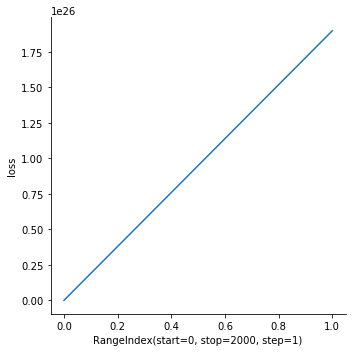

In [10]:
sns.relplot(x=hist.index, y="loss", kind="line", data=hist)

## Prepare for Kaggle submisison

In [11]:
data_test = pd.read_csv('sources/test.csv')
data_test.drop('Id',axis = 1, inplace = True)
data_test.fillna(0, inplace=True)
print(data_test.shape)

data_test_num = data_test.select_dtypes(exclude=['object'])

data_test_cat = data_test.select_dtypes(include=['object'])
# data_test_cat = pd.get_dummies(data_test_cat)

X_test = np.matrix(data_test_num)
X_test_cat = np.matrix(data_test_cat)

X_test = append(X_test, values=X_test_cat, axis=1)

print(f"X test {X_test.shape}")

(1459, 79)
X test (1459, 79)


In [12]:
if scale_data:
    X_test = scaler.transform(X_test[:,1:X_test.shape[1]]) # On applique le scaler sur les Surfaces du dataset de test (à l'excepion de l'id#colonne 1)

In [13]:
Y_test = model.predict(x=X_test)
Y_test = np.reshape(Y_test, Y_test.shape[0],)

ValueError: Error when checking input: expected input_1 to have shape (305,) but got array with shape (79,)

In [ ]:
data_test['Id'] = id_from_data_test
data_test['SalePrice'] = Y_test
data_test.drop(data_test.columns.difference(['Id','SalePrice']), 1, inplace=True)
data_test.to_csv('storage/kaggle_submission_file.csv', index=False)